In [1]:
import torch
from torchvision import transforms
from torchvision.models import alexnet, AlexNet_Weights
import numpy as np
from PIL import Image

from torchadv.attacks import PGD
from torchadv.utils.utils import get_available_device, show_images_diff

In [2]:
image_path = "./data/cropped_panda.jpg"
device = get_available_device()

In [3]:
# Open the image, resize it to 224x224 pixels
orig = Image.open(image_path).resize((224,224))

# Define the mean and standard deviation for normalization (ImageNet values)
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Define the transformations to be applied to the image
transform = transforms.Compose([
    transforms.CenterCrop(224),                 # Crop the center 224x224 pixels
    transforms.ToTensor(),                      # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=mean, std=std)    # Normalize with ImageNet mean and std
])

# Apply the transformations to the image
img_tensor = transform(orig)

# Add a batch dimension to the tensor for model input
img_tensor = img_tensor.unsqueeze(0)

# Move the tensor to the specified device (CPU or GPU)
img_tensor = img_tensor.to(device)

In [4]:
model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(device)
model.eval()

_, orig_y = torch.max(model(img_tensor), 1)
orig_y = orig_y.item()

attack = PGD(model)

target_labels=torch.tensor(538).unsqueeze(0).to(device)

adv = attack(img_tensor, labels=target_labels)

_, adv_y = torch.max(model(adv), 1)
adv_y = adv_y.item()

print(f"attack done: {orig_y} != {adv_y}")

attack done: 388 != 538


In [5]:
# Undo the normalization for visualization
adv = adv.squeeze(0)
adv = adv.detach().cpu().numpy()
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

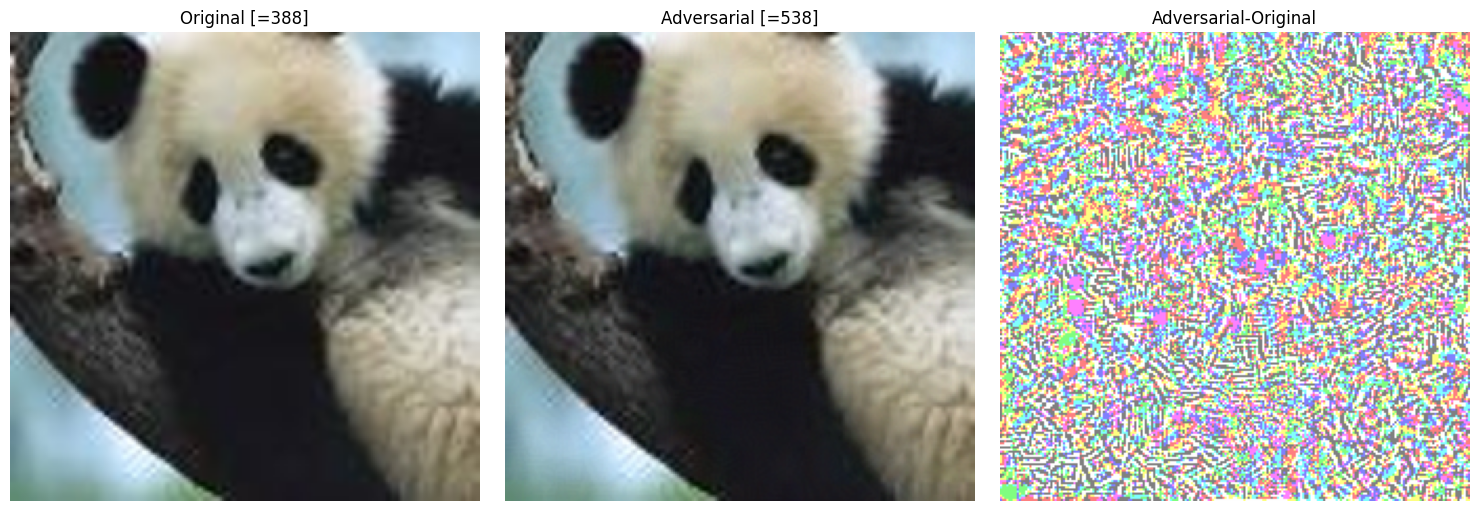

L0=125853 L2=69395.3882


In [6]:
# Visualization
show_images_diff(orig, orig_y, adv, adv_y)